<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/master/notebooks/unified_approach/4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 - Clustering process and validation



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/master/datasets/unified_approach/df_ma.csv"



df = pd.read_csv(df_url)
df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str), format='%Y-%m')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CODE_ATC        525 non-null    int64         
 1   DATE            525 non-null    datetime64[ns]
 2   HOSPI_CODE_UCD  525 non-null    int64         
 3   LIT_HC          525 non-null    float64       
 4   LIT_HP          525 non-null    float64       
 5   MONTH           525 non-null    int64         
 6   N_UFS           525 non-null    float64       
 7   PN_MEDICAL      525 non-null    float64       
 8   POPULATION      525 non-null    float64       
 9   P_MEDICAL       525 non-null    float64       
 10  QUANTITY        525 non-null    float64       
 11  QUANTITY_MA     525 non-null    float64       
 12  SEJ_MCO         525 non-null    float64       
 13  SEJ_SLD         525 non-null    float64       
 14  SEJ_SSR         525 non-null    float64       
 15  WEEK  

In [3]:
def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()

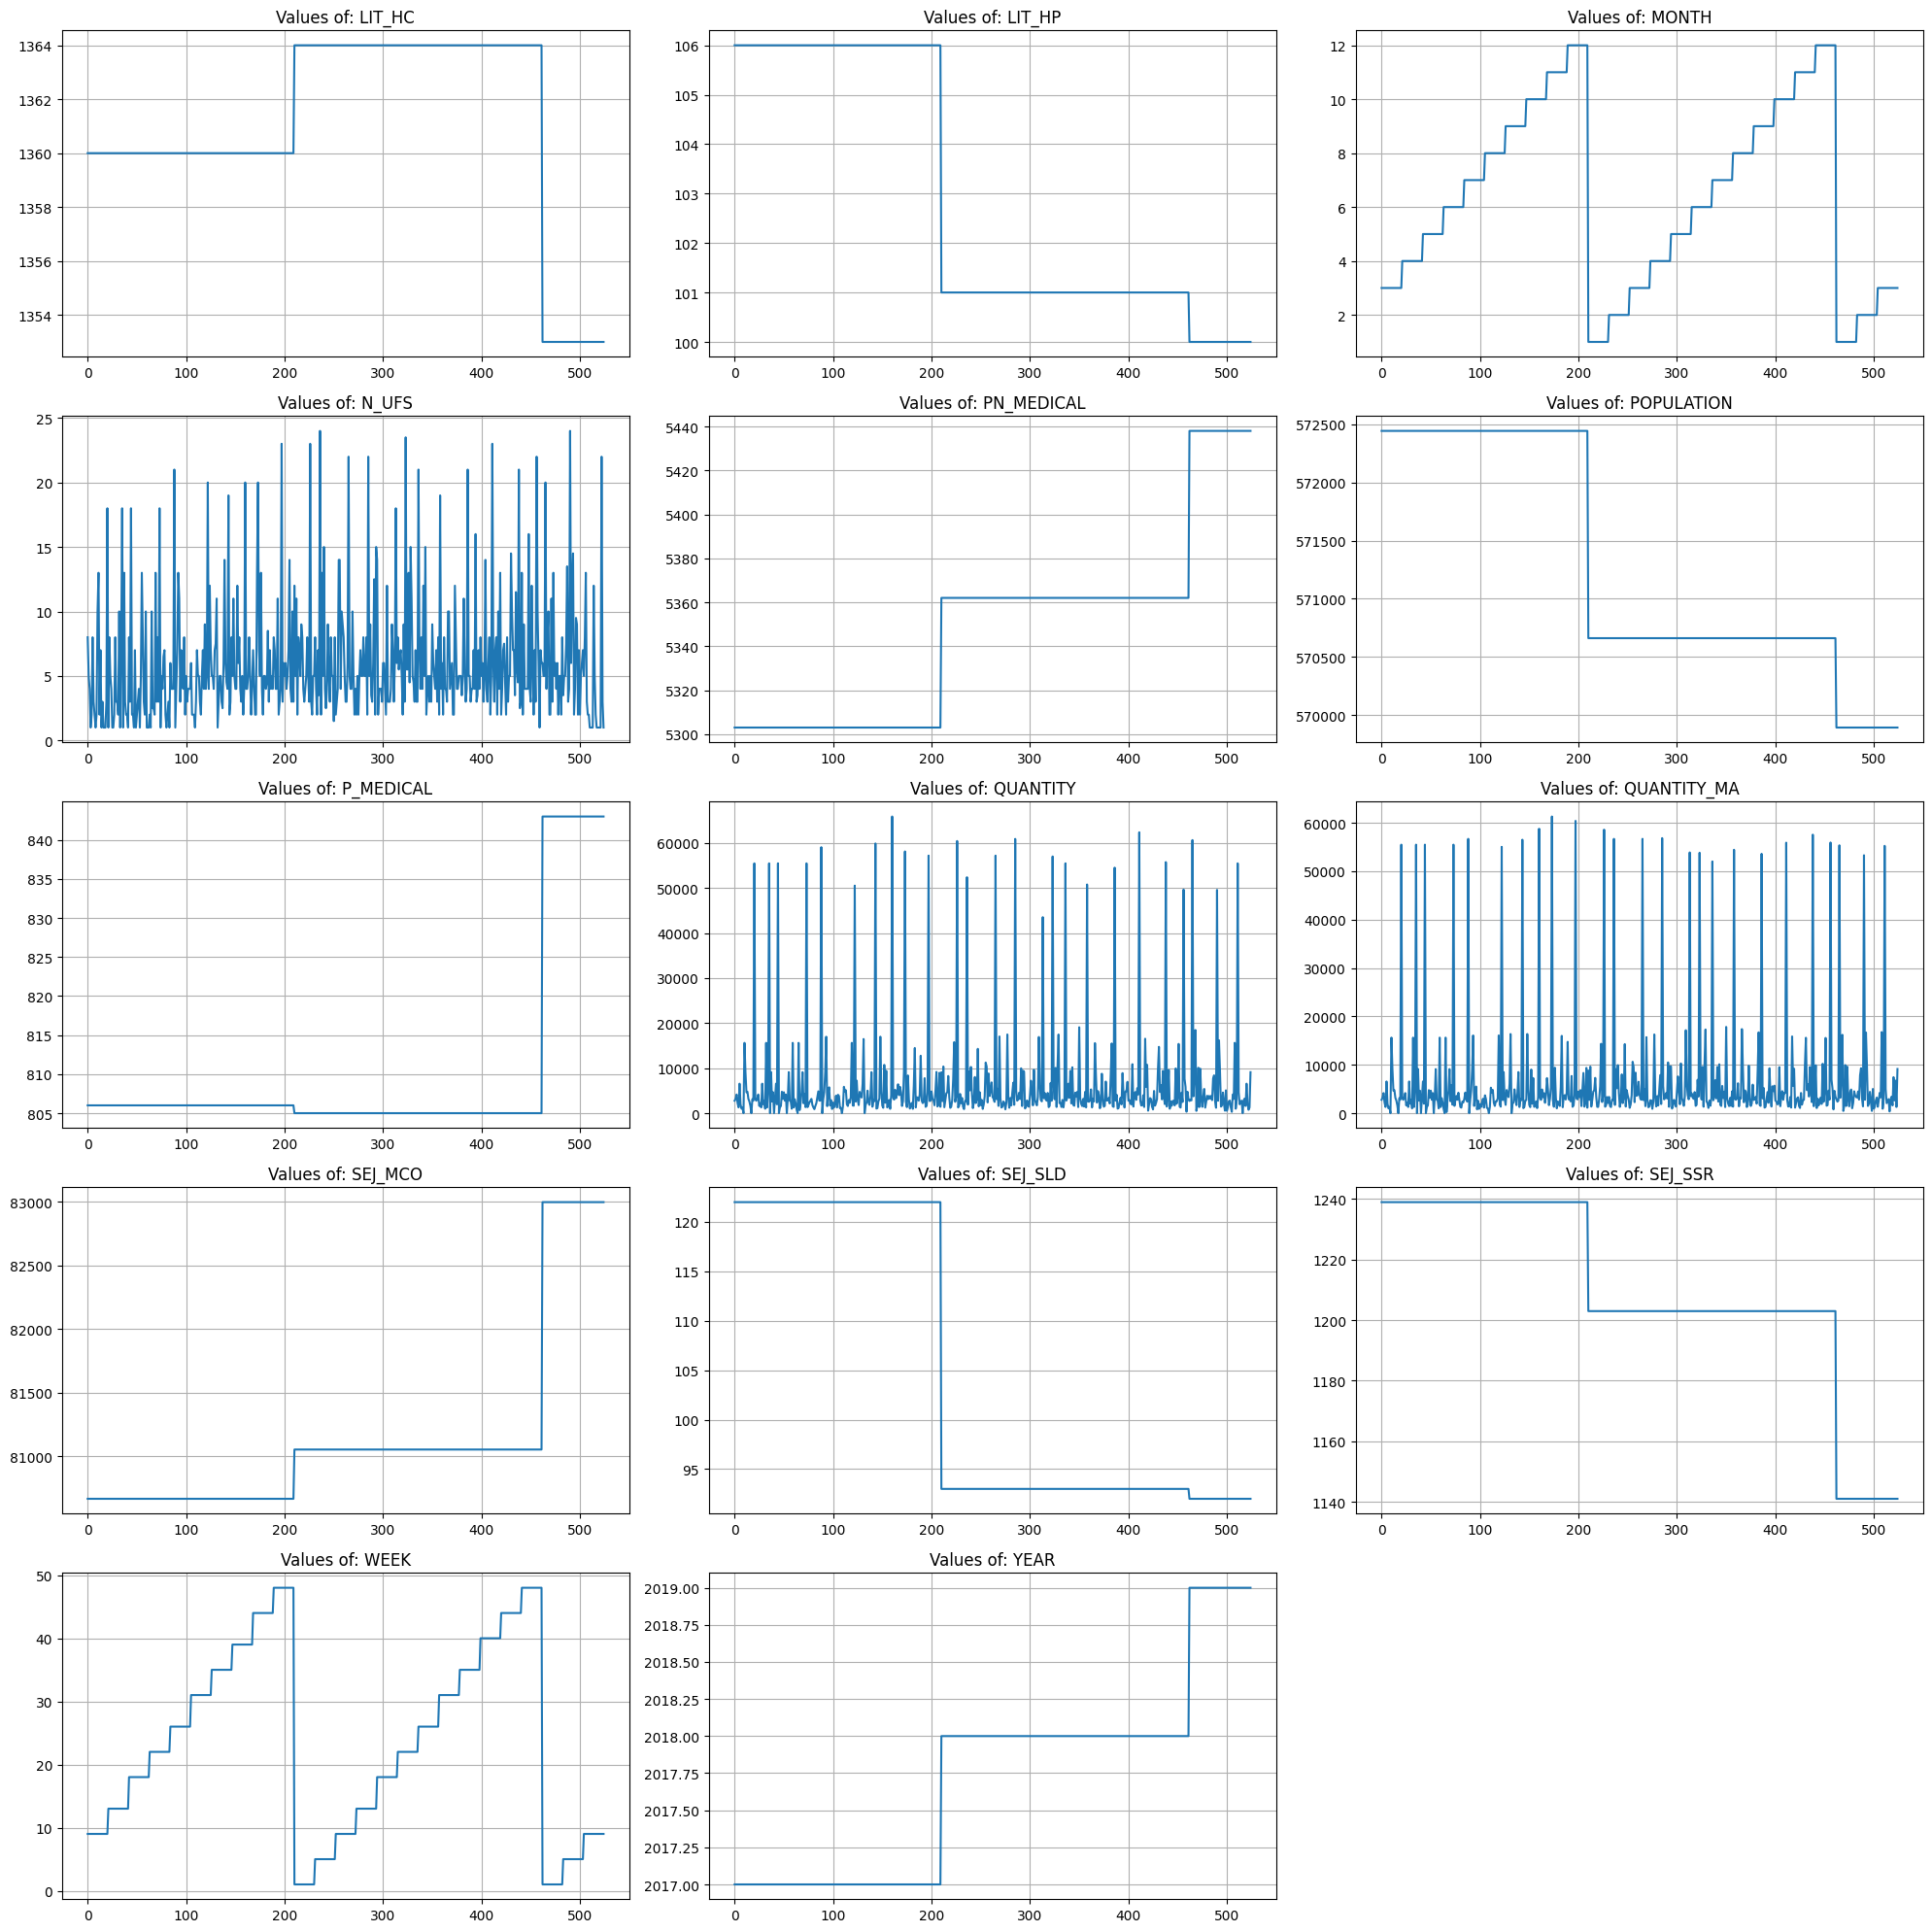

In [4]:
plot_df(df.drop(['DATE', 'HOSPI_CODE_UCD', 'CODE_ATC'], axis=1).copy(), n_cols=3)

In [5]:
def visualize_distribution(df, data_type='numerical', n_cols=3):
    if data_type == 'numerical':
        columns = df.select_dtypes(include=[int, float]).columns
    elif data_type == 'categorical':
        columns = df.select_dtypes(include=[object, 'string']).columns
    else:
        raise ValueError("Invalid data_type parameter. Supported values: 'numerical', 'categorical'")

    if len(columns) == 0:
        raise ValueError("No columns of the specified data type found in the DataFrame.")

    num_features = len(columns)
    n_rows = m.ceil(num_features / n_cols)

    # Handle the case when n_rows or n_cols is 1
    if n_rows == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 10))
        axes = [axes]  # Wrap the single axis in a list
    elif n_cols == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(10, 20))
        axes = [[ax] for ax in axes]  # Convert each axis to a list
    else:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    # Set a predefined color palette
    palette = sns.color_palette("Set3", n_colors=num_features)

    for i, column in enumerate(columns):
        ax = axes[i // n_cols][i % n_cols]  # Access the axis correctly
        if data_type == 'numerical':
            sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        elif data_type == 'categorical':
            sns.countplot(x=column, data=df, ax=ax, palette=[palette[i]])
            ax.tick_params(axis='x', rotation=45)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols][i % n_cols])

    plt.tight_layout()
    plt.show()

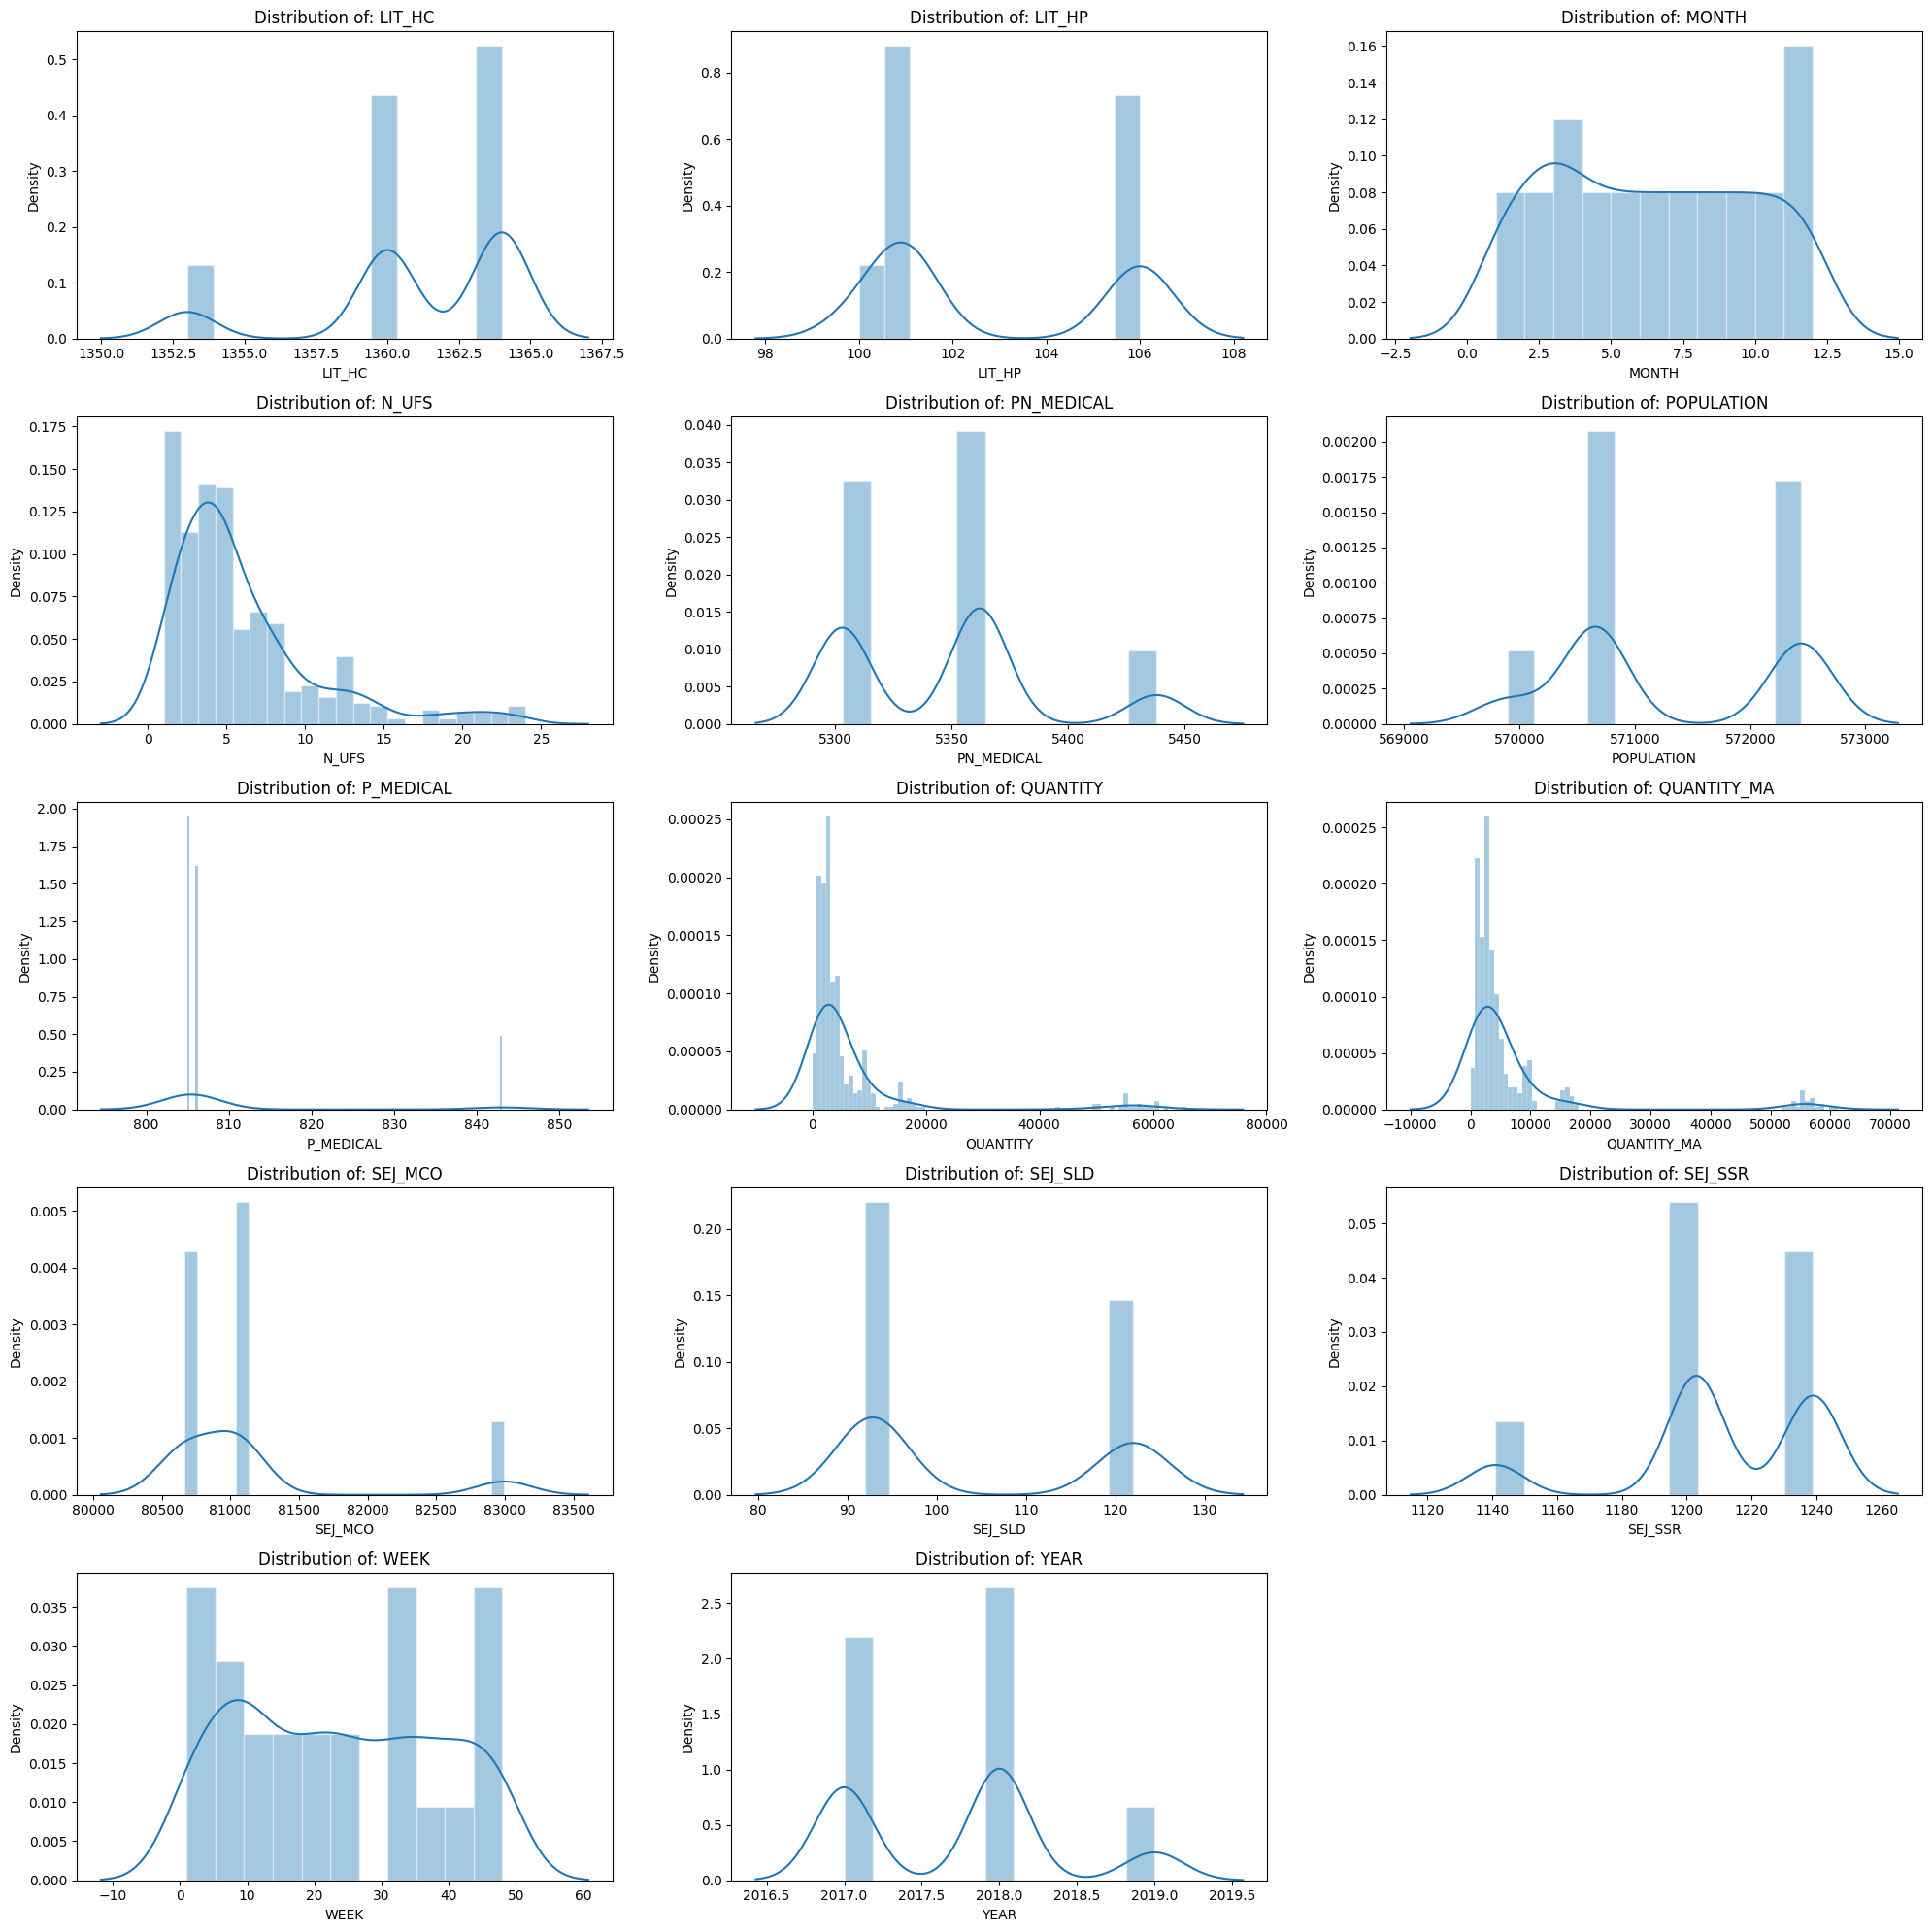

In [6]:
visualize_distribution(df.drop(['DATE', 'HOSPI_CODE_UCD', 'CODE_ATC'], axis=1).copy(), data_type='numerical', n_cols=3)

## 4.1 - Train, Test split

In [7]:
X = df.drop('DATE',axis=1).copy().values

X_train, X_test = train_test_split(X, test_size = 0.2, random_state=42)


## 4.2 - K-means model with different cluster composition
## &
## 4.3 - Model evaluation

In [8]:
def kmeans_clustering(X, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, init = 'k-means++', n_init=1, max_iter=300, random_state=42)
    model.fit(X)
    return model

In [9]:
def evaluate_kmeans_clustering(X_train, X_test, n_clusters=2, metric='euclidean', verbose = False):
    model = kmeans_clustering(X_train, n_clusters)
    y_pred = model.predict(X_test)
    silhouette = metrics.silhouette_score(X_test, y_pred, metric=metric)
    davies_bouldin = metrics.davies_bouldin_score(X_test, y_pred)
    calinski_harabasz = metrics.calinski_harabasz_score(X_test, y_pred)

    if verbose:
      metrics_string = '#'*10+' Metrics for test split - '+f'{n_clusters} clusters '+'#'*10
      print()
      print('#'*len(metrics_string))
      print(metrics_string)
      print()
      print(f'Silhouette Score: {round(silhouette, 2)}')
      print(f'Davies-Bouldin Score: {round(davies_bouldin, 2)}')
      print(f'Calinski-Harabasz Score: {round(calinski_harabasz, 2)}')
      print()
      print('#'*len(metrics_string))
      print('#'*len(metrics_string))
      print()

    return silhouette, davies_bouldin, calinski_harabasz

In [10]:
def visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores):

  # Find optimal cluster numbers based on the scores
  s_max = np.argmax(s_scores)+2
  dbs_min = np.argmin(dbs_scores)+2
  calinski_max = np.argmax(calinski_scores)+2

  # Print the best scores and cluster numbers
  string_array = '#'*10 + ' Metrics best performance for different clusters ' + '#'*10
  len_string_array = len(string_array)
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()
  print(string_array)
  print(f'Best score for Silhouette metric: {max(s_scores):.2f} for {s_max} clusters')
  print(f'Best score for Davies Bouldin metric: {min(dbs_scores):.2f} for {dbs_min} clusters')
  print(f'Best score for Calinski metric: {max(calinski_scores):.2f} for {calinski_max} clusters')
  print()
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()

  # Plot Silhouette scores
  x = np.arange(min_clusters, max_clusters+1)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

  # Plot Silhouette scores
  axs[0].stem(x, s_scores, linefmt='C0-', markerfmt='C0o', basefmt=' ')
  axs[0].set_xlabel('Number of Clusters')
  axs[0].set_ylabel('Silhouette Score')
  axs[0].set_title('Silhouette Scores for Different Cluster Numbers')
  axs[0].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[0].set_ylim([0, 1])
  axs[0].grid(True)

  # Plot Davies Bouldin Scores
  axs[1].stem(x, dbs_scores, linefmt='C1-', markerfmt='C1o', basefmt=' ')
  axs[1].set_xlabel('Number of Clusters')
  axs[1].set_ylabel('Davies Bouldin Score')
  axs[1].set_title('Davies Bouldin Scores for Different Cluster Numbers')
  axs[1].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[1].set_ylim([0, 1])
  axs[1].grid(True)

  # Plot Calinski scores
  axs[2].stem(x, calinski_scores, linefmt='C2-', markerfmt='C2o', basefmt=' ')
  axs[2].set_xlabel('Number of Clusters')
  axs[2].set_ylabel('Calinski Score')
  axs[2].set_title('Calinski Scores for Different Cluster Numbers')
  axs[2].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[2].grid(True)

  plt.show()




---------------------------------------------------------------------
---------------------------------------------------------------------

########## Metrics best performance for different clusters ##########
Best score for Silhouette metric: 0.84 for 7 clusters
Best score for Davies Bouldin metric: 0.15 for 7 clusters
Best score for Calinski metric: 133509.18 for 21 clusters

---------------------------------------------------------------------
---------------------------------------------------------------------



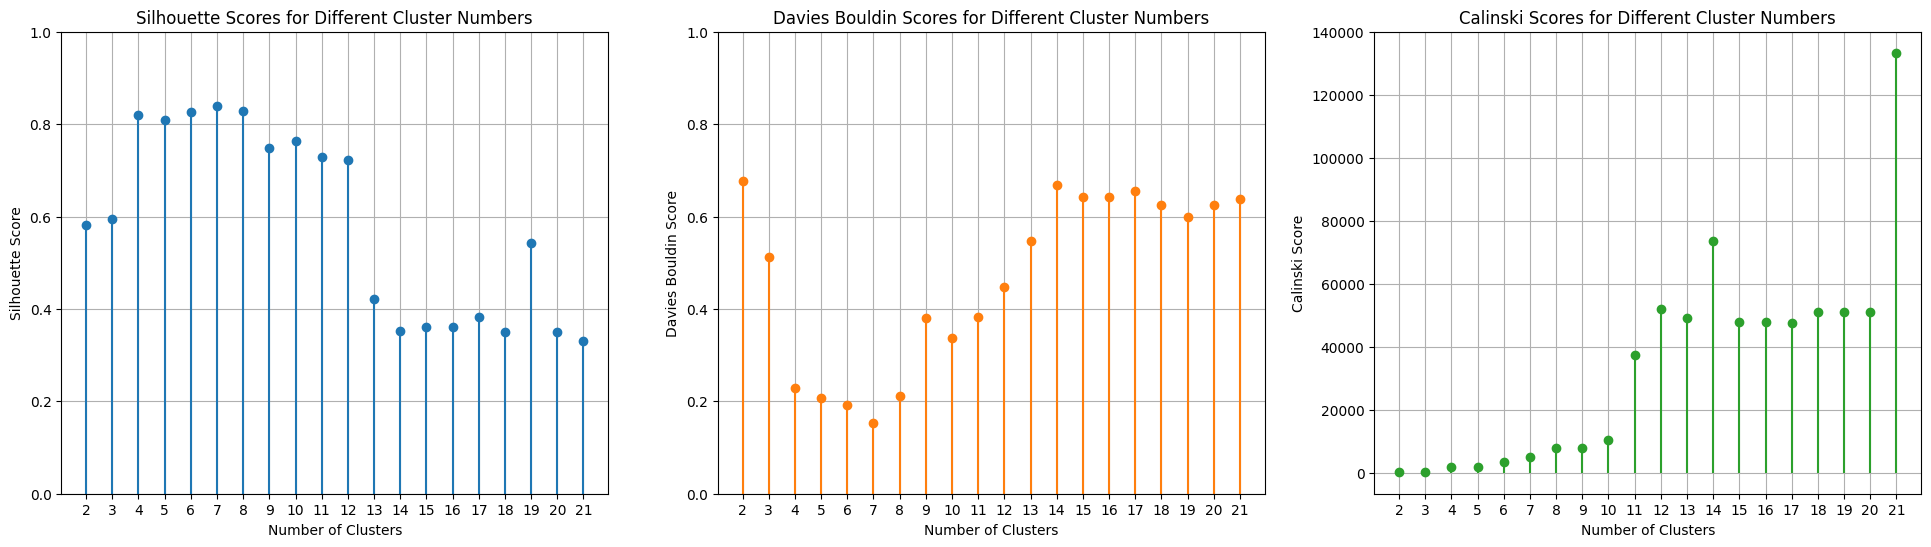

In [11]:
min_clusters = 2
max_clusters = len(df.HOSPI_CODE_UCD.unique())

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)
calinski_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for n_clusters in clusters:

  s_scores[n_clusters-2], dbs_scores[n_clusters-2], calinski_scores[n_clusters-2] =  evaluate_kmeans_clustering(X_train, X_test, n_clusters)

visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores)

## 4.4 - Fit test

In [12]:
from IPython.display import display

def model_validation(df, X, columns, n_clusters = 2):

  model = KMeans(n_clusters=n_clusters, init = 'k-means++', n_init=1, max_iter=300, random_state=42)
  labels  = model.fit_predict(X)

  df['cluster'] = labels

  description = df.groupby("cluster")[columns]
  n_drugs = description.size()
  description = description.median()
  description['n_drugs'] = n_drugs
  display(description.head(n_clusters))
  return labels

In [13]:
def visu_clusters(df, x1, x2, labels):
  plt.figure(figsize=(12, 6))
  scatter = plt.scatter(df[x1].astype('string'), df[x2], c=labels, s=5, cmap='rainbow')
  plt.xlabel(x1)
  plt.ylabel(x2)
  plt.title(f'Scatter plot of {x1}' + f' over {x2}')
  plt.xticks(rotation=90)
  plt.grid()
  plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], title="Categories")
  plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def visu_clusters_3d(df1, df2, df3, df4, x1, x2, labels1, labels2, labels3, labels4):
    fig = plt.figure(figsize=(24, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for Hospital 1
    ax.scatter(df1[x1].astype('string'), np.ones(len(df1)), df1[x2], c=labels1, s=5, cmap='rainbow')

    # Scatter plot for Hospital 2
    ax.scatter(df2[x1].astype('string'), 2 * np.ones(len(df2)), df2[x2], c=labels2, s=5, cmap='rainbow')

    # Scatter plot for Hospital 3
    ax.scatter(df3[x1].astype('string'), 3 * np.ones(len(df3)), df3[x2], c=labels3, s=5, cmap='rainbow')

    # Scatter plot for Hospital 4
    ax.scatter(df4[x1].astype('string'), 4 * np.ones(len(df4)), df4[x2], c=labels4, s=5, cmap='rainbow')

    # Set labels and title
    ax.set_xlabel(x1)
    ax.set_ylabel('Hospital')
    ax.set_zlabel(x2)
    ax.set_title('3D Scatter Plot')

    # Set y-ticks and labels for hospitals
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(['Hospital 1', 'Hospital 2', 'Hospital 3', 'Hospital 4'])

    # Increase space between ticks and axis label
    ax.tick_params(axis='x', rotation=90, pad=10)
    ax.tick_params(axis='y', pad=10)

    # Show the plot
    plt.show()


In [14]:
def visu_clusters_all(df1, df2, df3, df4, x1, x2, labels1, labels2, labels3, labels4):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 18))

  # Hospital 1
  axs[0, 0].scatter(df1[x1].astype('string'), df1[x2], c=labels1, s=5, cmap='rainbow')
  axs[0, 0].set_xlabel(x1)
  axs[0, 0].set_ylabel(x2)
  axs[0, 0].set_title(f'Scatter plot of {x1} over {x2} - Hospital 1')
  axs[0, 0].grid(True)
  axs[0, 0].tick_params(axis='x', rotation=90, pad=10)  # Increase space between ticks and axis label

  # Hospital 2
  axs[0, 1].scatter(df2[x1].astype('string'), df2[x2], c=labels2, s=5, cmap='rainbow')
  axs[0, 1].set_xlabel(x1)
  axs[0, 1].set_ylabel(x2)
  axs[0, 1].set_title(f'Scatter plot of {x1} over {x2} - Hospital 2')
  axs[0, 1].grid(True)
  axs[0, 1].tick_params(axis='x', rotation=90, pad=10)  # Increase space between ticks and axis label

  # Hospital 3
  axs[1, 0].scatter(df3[x1].astype('string'), df3[x2], c=labels3, s=5, cmap='rainbow')
  axs[1, 0].set_xlabel(x1)
  axs[1, 0].set_ylabel(x2)
  axs[1, 0].set_title(f'Scatter plot of {x1} over {x2} - Hospital 3')
  axs[1, 0].grid(True)
  axs[1, 0].tick_params(axis='x', rotation=90, pad=10)  # Increase space between ticks and axis label

  # Hospital 4
  axs[1, 1].scatter(df4[x1].astype('string'), df4[x2], c=labels4, s=5, cmap='rainbow')
  axs[1, 1].set_xlabel(x1)
  axs[1, 1].set_ylabel(x2)
  axs[1, 1].set_title(f'Scatter plot of {x1} over {x2} - Hospital 4')
  axs[1, 1].grid(True)
  axs[1, 1].tick_params(axis='x', rotation=90, pad=10)  # Increase space between ticks and axis label

  plt.subplots_adjust(hspace=0.4)  # Increase space between subplots
  plt.show()

,QUANTITY,POPULATION,P_MEDICAL,PN_MEDICAL,N_UFS,LIT_HC,SEJ_SLD,QUANTITY_MA,n_drugs
cluster,,,,,,,,,
0,2641.0,570662.0,806.0,5362.0,4.25,1360.0,93.0,2608.166667,150
1,3240.0,570662.0,806.0,5362.0,5.00,1360.0,93.0,3242.333333,75
2,2760.0,570662.0,806.0,5362.0,6.00,1360.0,93.0,2756.666667,100
3,3557.5,570662.0,806.0,5362.0,4.25,1360.0,93.0,3585.166667,200


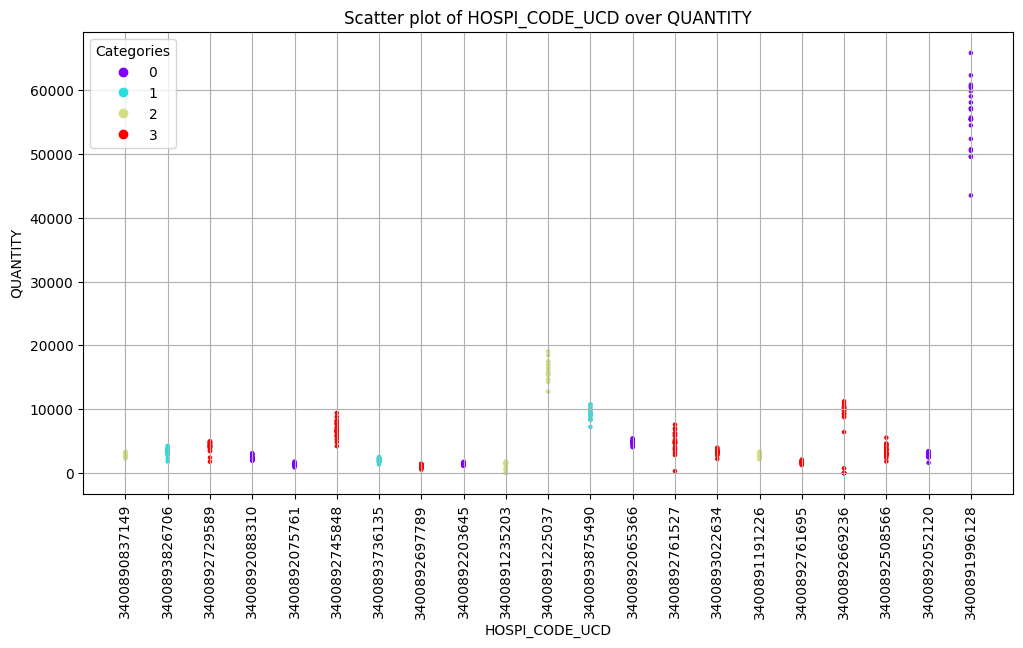

In [17]:
labels = model_validation(df.copy(), X, ["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL", "N_UFS", "LIT_HC", "SEJ_SLD", "QUANTITY_MA"], n_clusters = 4)
print()
visu_clusters(df.copy(), 'HOSPI_CODE_UCD', 'QUANTITY', labels)

### Saving the datasets with clusters

In [18]:
df['CLUSTER'] = labels

df.to_csv('df_clustered.csv', index=False)